In [1]:
# load libraries
import pandas as pd
import os
import numpy as np
import datetime
from torch.utils.data import Dataset, DataLoader
from torch import save

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change me, have to point to the Meteotrentino drive folder
wk =  "/content/drive/My Drive/10. Meteotrentino/"

# folder for the csv
subfolder = "Dati csv convalidati/"

# select the filename, make me dynamic
selected_dataset = "temperatura1_A.csv"

In [ ]:
# data_path = wk+subfolder+selected_dataset
data_path = "../../../temperatura1_A.csv"

In [ ]:
df_row_data = pd.read_csv(
  data_path,
  sep = ";", # not a CSV, separator is ';'
  header = None, # no header
  dtype = {'0' : str, '1': str, '2': str, '3' : np.float64, '4':int} # Daniele: added the validation code so we can train on validated data (no need of classes, just distinguish between good and bad data)
  ) 

# define a header 
df_row_data = df_row_data.set_axis(
    ['label', 'date', 'time', 'value','validation_code'],
    axis = 1,
    inplace = False
)
df_row_data['datetime'] = pd.to_datetime(df_row_data['date']+" "+df_row_data['time'], format = '%d/%m/%Y %H:%M')
df_row_data

,label,date,time,value,validation_code,datetime
0,T0009,01/01/2014,00:00,-2.1,1,2014-01-01 00:00:00
1,T0009,01/01/2014,00:15,-2.3,1,2014-01-01 00:15:00
2,T0009,01/01/2014,00:30,-2.2,1,2014-01-01 00:30:00
3,T0009,01/01/2014,00:45,-2.3,1,2014-01-01 00:45:00
4,T0009,01/01/2014,01:00,-2.5,1,2014-01-01 01:00:00
...,...,...,...,...,...,...
11763686,T0227,31/12/2021,22:45,8.1,1,2021-12-31 22:45:00
11763687,T0227,31/12/2021,23:00,8.2,1,2021-12-31 23:00:00
11763688,T0227,31/12/2021,23:15,8.1,1,2021-12-31 23:15:00
11763689,T0227,31/12/2021,23:30,8.0,1,2021-12-31 23:30:00


In [ ]:
# select a single station
df_single_station = df_row_data[df_row_data['label'] == 'T0071'].reset_index(drop=True)
print(np.unique(df_single_station['validation_code'].values,return_counts=True))
# print(np.unique(df_row_data['label'].values))

(array([  1, 255]), array([280285,      1]))


In [ ]:
print(df_single_station)

        label        date   time  value  validation_code            datetime
0       T0071  01/01/2014  00:00   -6.5                1 2014-01-01 00:00:00
1       T0071  01/01/2014  00:15   -8.2                1 2014-01-01 00:15:00
2       T0071  01/01/2014  00:30   -7.5                1 2014-01-01 00:30:00
3       T0071  01/01/2014  00:45   -7.2                1 2014-01-01 00:45:00
4       T0071  01/01/2014  01:00   -7.8                1 2014-01-01 01:00:00
...       ...         ...    ...    ...              ...                 ...
280281  T0071  31/12/2021  22:45    0.4                1 2021-12-31 22:45:00
280282  T0071  31/12/2021  23:00    0.0                1 2021-12-31 23:00:00
280283  T0071  31/12/2021  23:15    0.3                1 2021-12-31 23:15:00
280284  T0071  31/12/2021  23:30    0.4                1 2021-12-31 23:30:00
280285  T0071  31/12/2021  23:45   -0.1                1 2021-12-31 23:45:00

[280286 rows x 6 columns]


In [ ]:
from importlib import reload  # Python 3.4+
import sys
# !git clone https://github.com/eliazonta/AI-Challenge-HIT
# sys.path.append("/content/AI-Challenge-HIT/python_code/notebooks")
sys.path.append("/mnt/d/MeteoTrentino/AI-Challenge-HIT/python_code/notebooks")
import TSF.data_splitter
TSF.data_splitter = reload(TSF.data_splitter)
from TSF.data_splitter import *
# new_data = split_df_for_TSF(df_single_station.iloc[0:10], 24, 1, ".")

# split the data for the time series forecasting (24 hours of training, 1 hour of prediction)
PERIOD = 24
PREDICTION = 1
df = df_single_station#.iloc[0:120]
df_train,df_prediction,n_previsions = split_df_for_TSF(df, 24, 1)
# df_train = df_train.reset_index(drop=True)
# df_prediction = df_prediction.reset_index(drop=True)
# np.unique(df_prediction[['val_0','val_1','val_2','val_3']].values, return_counts=True)
print(df_prediction)

      sensor_code         in_datetime    0    1    2    3  val_0  val_1  \
0           T0071 2014-01-01 00:15:00 -5.6 -5.4 -6.0 -6.0    1.0    1.0   
1           T0071 2014-01-01 01:15:00 -6.0 -6.5 -6.8 -6.7    1.0    1.0   
2           T0071 2014-01-01 02:15:00 -6.5 -6.8 -7.0 -6.4    1.0    1.0   
3           T0071 2014-01-01 03:15:00 -6.6 -6.2 -5.7 -6.6    1.0    1.0   
4           T0071 2014-01-01 04:15:00 -6.1 -6.4 -6.2 -6.6    1.0    1.0   
...           ...                 ...  ...  ...  ...  ...    ...    ...   
65357       T0071 2021-12-30 18:15:00  4.1  2.7  4.6  2.5    1.0    1.0   
65358       T0071 2021-12-30 19:15:00  2.9  3.8  1.5  1.2    1.0    1.0   
65359       T0071 2021-12-30 20:15:00  0.8  1.8  1.0  0.8    1.0    1.0   
65360       T0071 2021-12-30 21:15:00  0.3  0.0 -0.1  0.1    1.0    1.0   
65361       T0071 2021-12-30 22:15:00  0.5  2.5  0.4  0.0    1.0    1.0   

       val_2  val_3  
0        1.0    1.0  
1        1.0    1.0  
2        1.0    1.0  
3        1.

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
  def __init__(self, df_train, df_test, transform = None, target_transform = None):
    self.features = torch.FloatTensor(df_train.drop(['sensor_code','in_datetime'],axis=1).values)
    ### standardize the data
    ########################## TO DO: THE STANDARDIZATION MUST INCLUDE THE TARGET!!! 
    means = self.features.mean(dim=1, keepdim=True)
    stds = torch.clamp(self.features.std(dim=1, keepdim=True),min=1)
    self.features = (self.features - means) / stds
    self.target = torch.FloatTensor(df_test.drop(['sensor_code','in_datetime']+[f"val_{idx}" for idx in range(n_previsions)],axis=1).values)
    self.target = (self.target - means) / stds
    
    self.sensor_code = df_train['sensor_code'].values
    self.in_datetime = df_train['in_datetime'].values
    
    self.labels = torch.FloatTensor(df_test[[f"val_{idx}" for idx in range(n_previsions)]].values)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.sensor_code)

  def __getitem__(self, idx):
    sensor_code = self.sensor_code[idx]
    date = self.in_datetime[idx]
    features = self.features[idx]
    labels = self.labels[idx]
    target = self.target[idx]
    return {"sensor_code": sensor_code, "date":date,"features": features, "target":target,"labels":labels}

In [87]:
splits = ['train','test']
shuffle = {'train':True,'test':False}
dataset = {}

# split data in training and test (to check generalization)
# training_features = df_train.sample(frac=0.8)
# training_target = df_prediction.iloc[training_features.index.values]
# test_features = df_train.drop(training_features.index)
# test_target = df_prediction.iloc[test_features.index]

# training_features = training_features.reset_index(drop=True)
# training_target = training_target.reset_index(drop=True)
# test_features = test_features.reset_index(drop=True)
# test_target = test_target.reset_index(drop=True)

from torch import save,load
dataset_path = wk+"DatasetPytorch/umidità/"
dataset['train'] = load(dataset_path+'T0354_train_umidità_tsf.pt')
dataset['test'] = load(dataset_path+'T0354_test_umidità_tsf.pt')
# dataset['train'] = CustomDataset(training_features, training_target)
# dataset['test'] = CustomDataset(test_features, test_target)
# save(dataset['train'], 'T0071_train_solar_rad_tsf.pt')
# save(dataset['test'], 'T0071_test_solar_rad_tsf.pt')


# b_size = {'train':len(dataset['train']),
b_size = {'train':64,
          'test':len(dataset['test'])}

dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x,
                                            drop_last=True)
                                            #num_workers=int(opt.workers),
                                            #worker_init_fn=(None if opt.manualseed == -1
                                            #else lambda x: np.random.seed(opt.manualseed)))
            for x in splits}

In [91]:
from collections.abc import Sequence
from importlib import reload  # Python 3.4+
import torch
import sys
from torch import nn
!git clone https://github.com/eliazonta/AI-Challenge-HIT
sys.path.append("/content/AI-Challenge-HIT/python_code/notebooks/AnomalyDetection")
import LSTMs
LSTMs = reload(LSTMs)
from LSTMs import SingleLSTMCell,LSTM

device = torch.device("cuda")
sequence_length = dataset['train'][0]['features'].size(0)
pred_length = dataset['train'][0]['target'].size(0)
# Instantiate the model with hyperparameters
# model = LSTM(input_size=1, output_size=1, hidden_dim=32, device = device)
# We'll also set the model to the device that we defined earlier (default is CPU)
# Daniele: Not sure if this is useless now, should check
model = model.to(device)
#model.load_state_dict(torch.load('T0065_rad_sol_model.pt', map_location=torch.device('cpu')))

# Define hyperparameters
lr = 5e-6

# Define Loss, Optimizer
criterion = nn.MSELoss()#CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

from tqdm import tqdm
n_epochs = 10
for epoch in range(1, n_epochs + 1):
    for data in tqdm(dataloader['train'], leave=True, total=len(dataloader['train'])):
        batch_input_features = torch.stack([v["features"] for v in data]).to(device)
        target_features = torch.stack([v["target"] for v in data]).to(device)
        output = model(batch_input_features,pred_length)
        output = output.to(device)[:,-pred_length:]
        loss = criterion(output, target_features)
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        # print("Loss: {:.4f}".format(loss.item()))
    print("Loss: {:.4f}".format(loss.item()))
    if loss.item() < 0.15:
        break

fatal: destination path 'AI-Challenge-HIT' already exists and is not an empty directory.


100%|██████████| 844/844 [00:05<00:00, 148.76it/s]


Loss: 0.4993


100%|██████████| 844/844 [00:05<00:00, 156.94it/s]


Loss: 0.2064


100%|██████████| 844/844 [00:06<00:00, 126.47it/s]


Loss: 0.3384


100%|██████████| 844/844 [00:06<00:00, 123.54it/s]


Loss: 0.3331


100%|██████████| 844/844 [00:06<00:00, 125.04it/s]


Loss: 0.3883


100%|██████████| 844/844 [00:08<00:00, 104.51it/s]

Loss: 0.1437


In [92]:
torch.save(model.state_dict(), wk+"TrainedModels/"+"T0354_humidity_model.pt")

In [100]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

sample = dataset["test"]
### use below a list of min and max indexes in case of memory overflow, otherwise set to none
restriction = None#[20000,30000]

def extract_quantity_from_dataset(dataset,label_of_quantity,indexes=None,device='cpu'):
  # returns a pytorch array of the given quantity
  # optional: restrict the dataset to some indexes (for memory allocation reasons)
  if(indexes):
    pt_tensor = torch.stack([dataset[i][label_of_quantity] for i in range(min(indexes),max(indexes)+1)]).to(device)
  else: pt_tensor = torch.stack([v[label_of_quantity] for v in dataset]).to(device)
  return pt_tensor

sample_tensor_validation = extract_quantity_from_dataset(sample,"labels",restriction)

sample_tensor_features = extract_quantity_from_dataset(sample,"features",restriction,device=device) 

sample_tensor_target = extract_quantity_from_dataset(sample,"target",restriction,device=device)

sensor_code = [v['sensor_code'] for v in sample][0]
date = pd.to_datetime([v['date'] for v in sample]).strftime("%d/%m/%Y %H:%M") 

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,pred_length)

# Find the data with highest loss
criterion = nn.MSELoss(reduction='none')
TOP_K_loss = 10
loss = criterion(reconstructed[:,-pred_length:], sample_tensor_target).mean(dim=1)
top_loss, top_loss_indexes = torch.topk(loss, TOP_K_loss, dim=0)
# # confidence interval
# # rolling mean over n_steps
# n_steps = 3
# time_series_df = pd.DataFrame(original_signal)
# line = time_series_df.rolling(n_steps).mean()
# # 98% confidence
# line_deviation = 2.326 * time_series_df.rolling(n_steps).std()
# under_line = (line - line_deviation)[0]
# over_line = (line + line_deviation)[0]

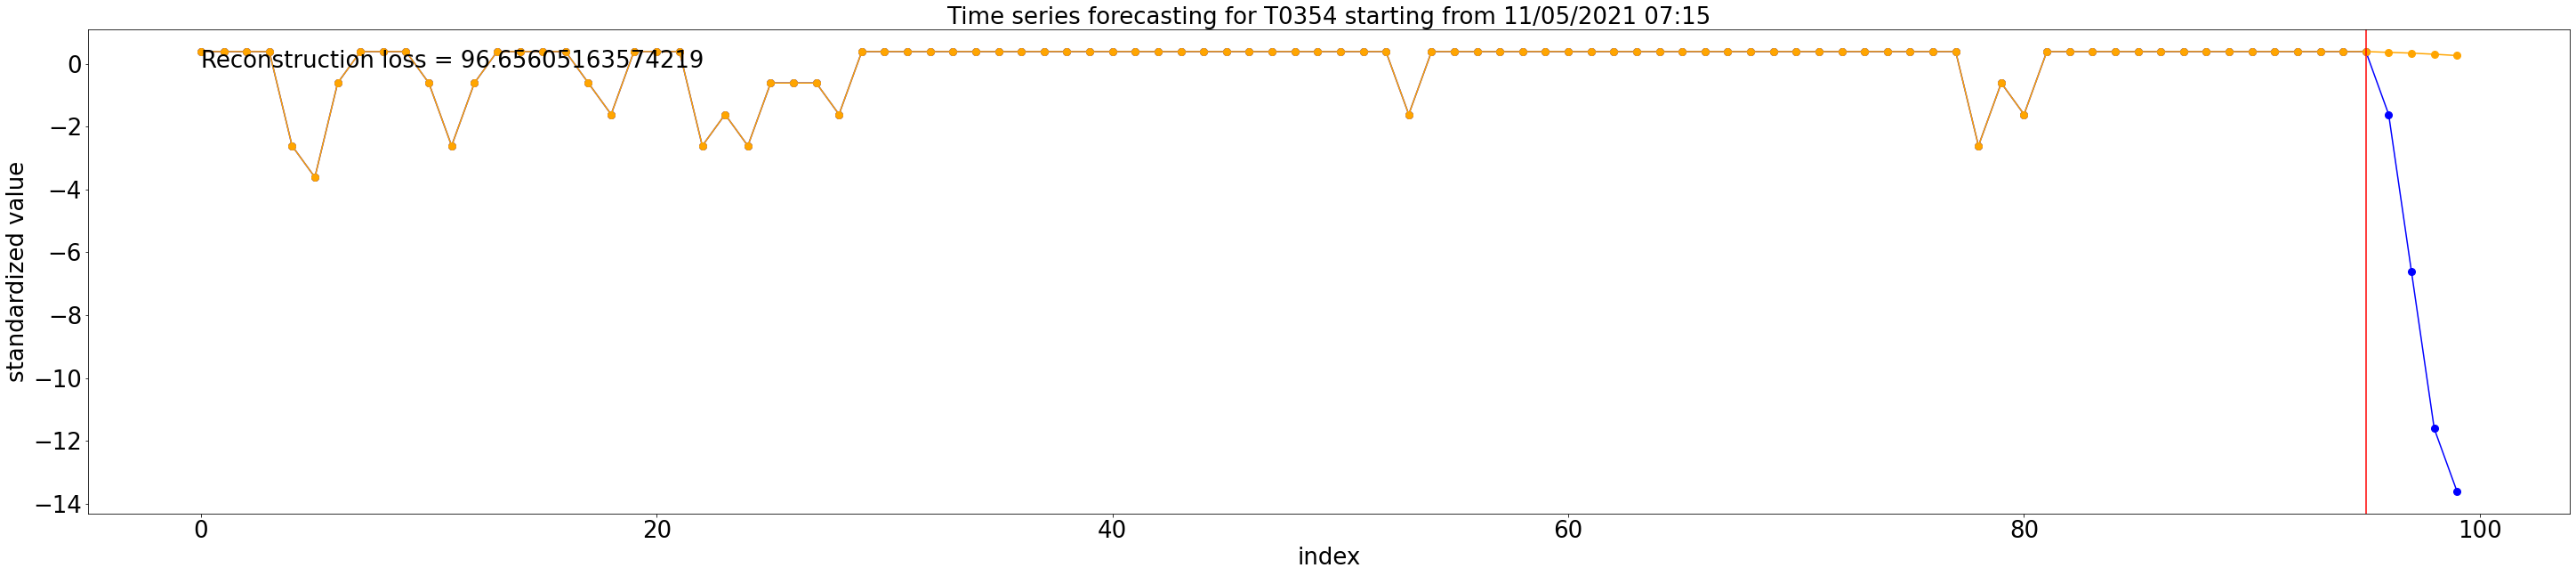

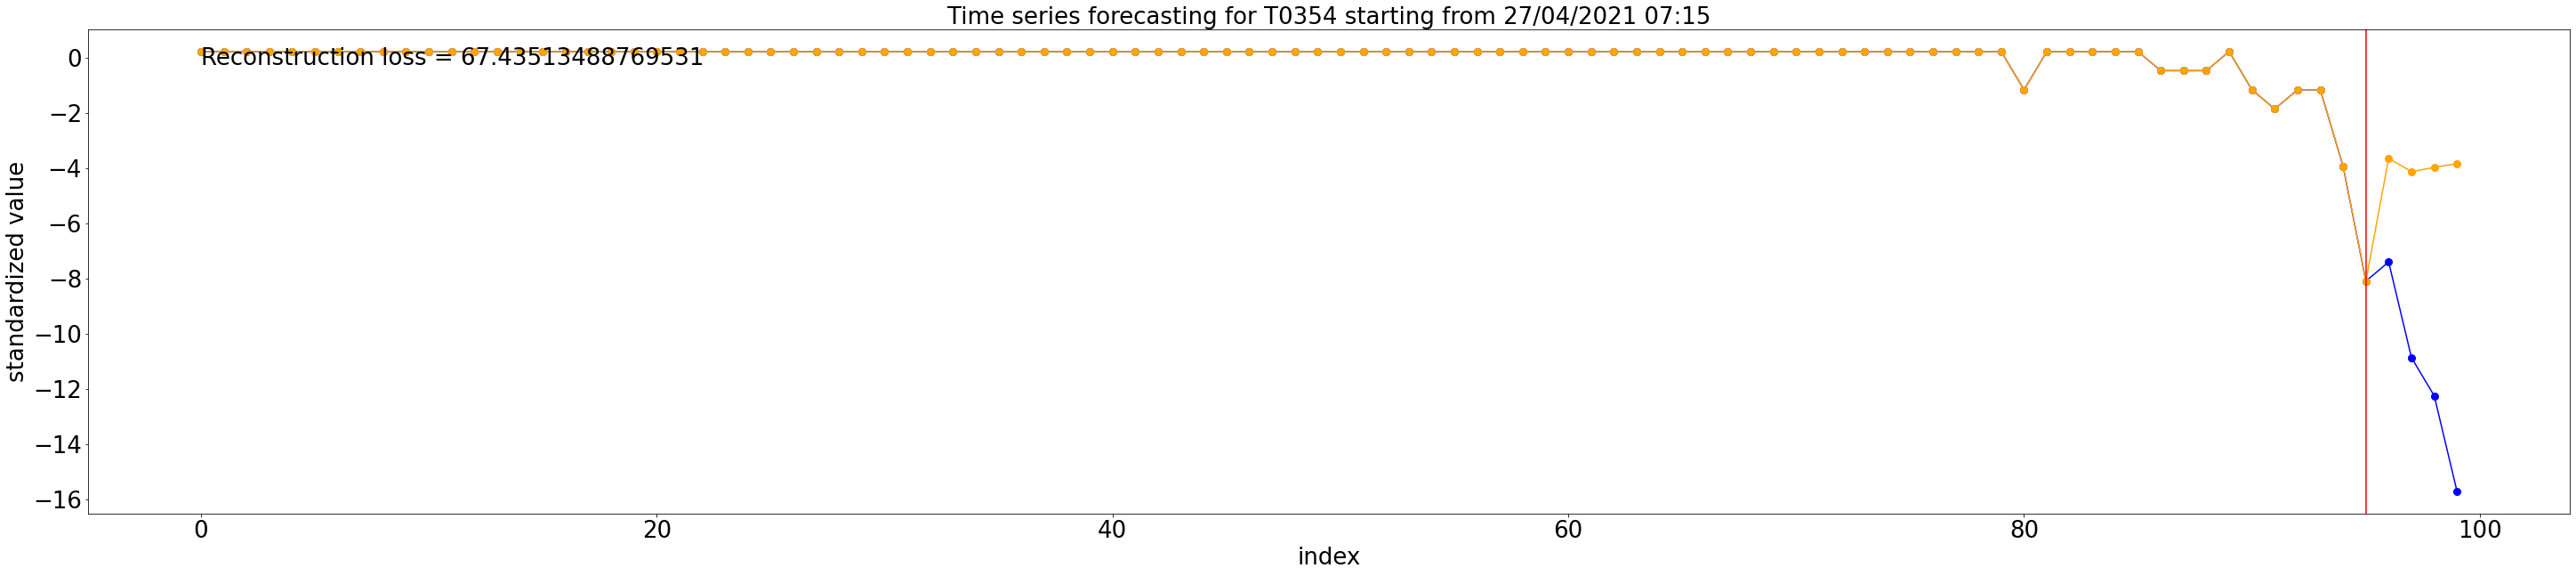

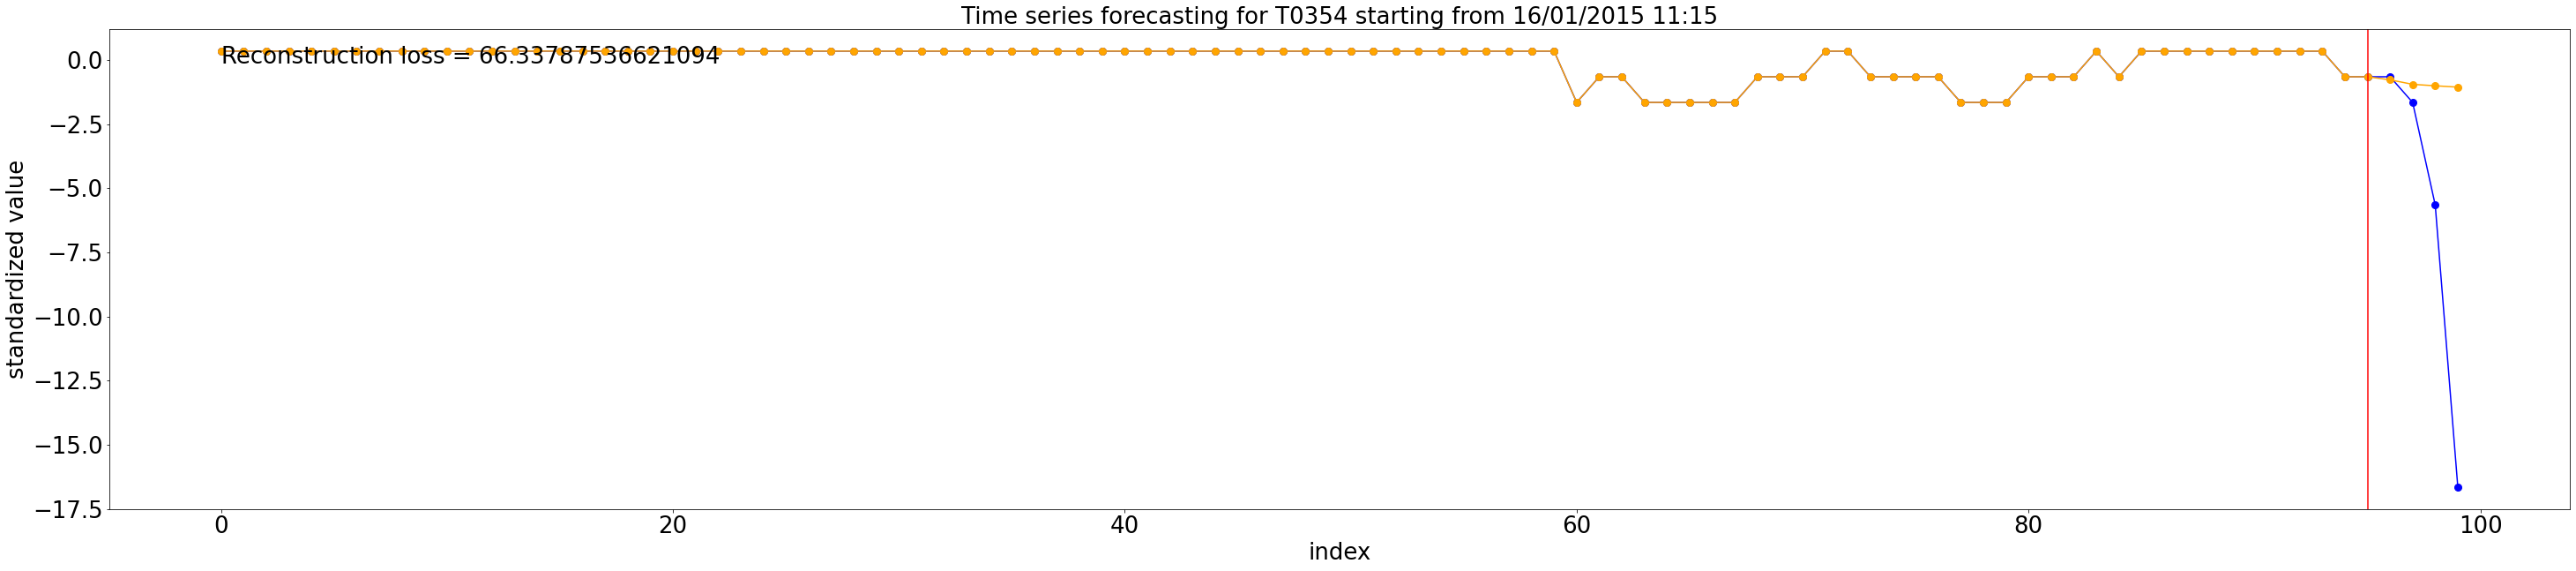

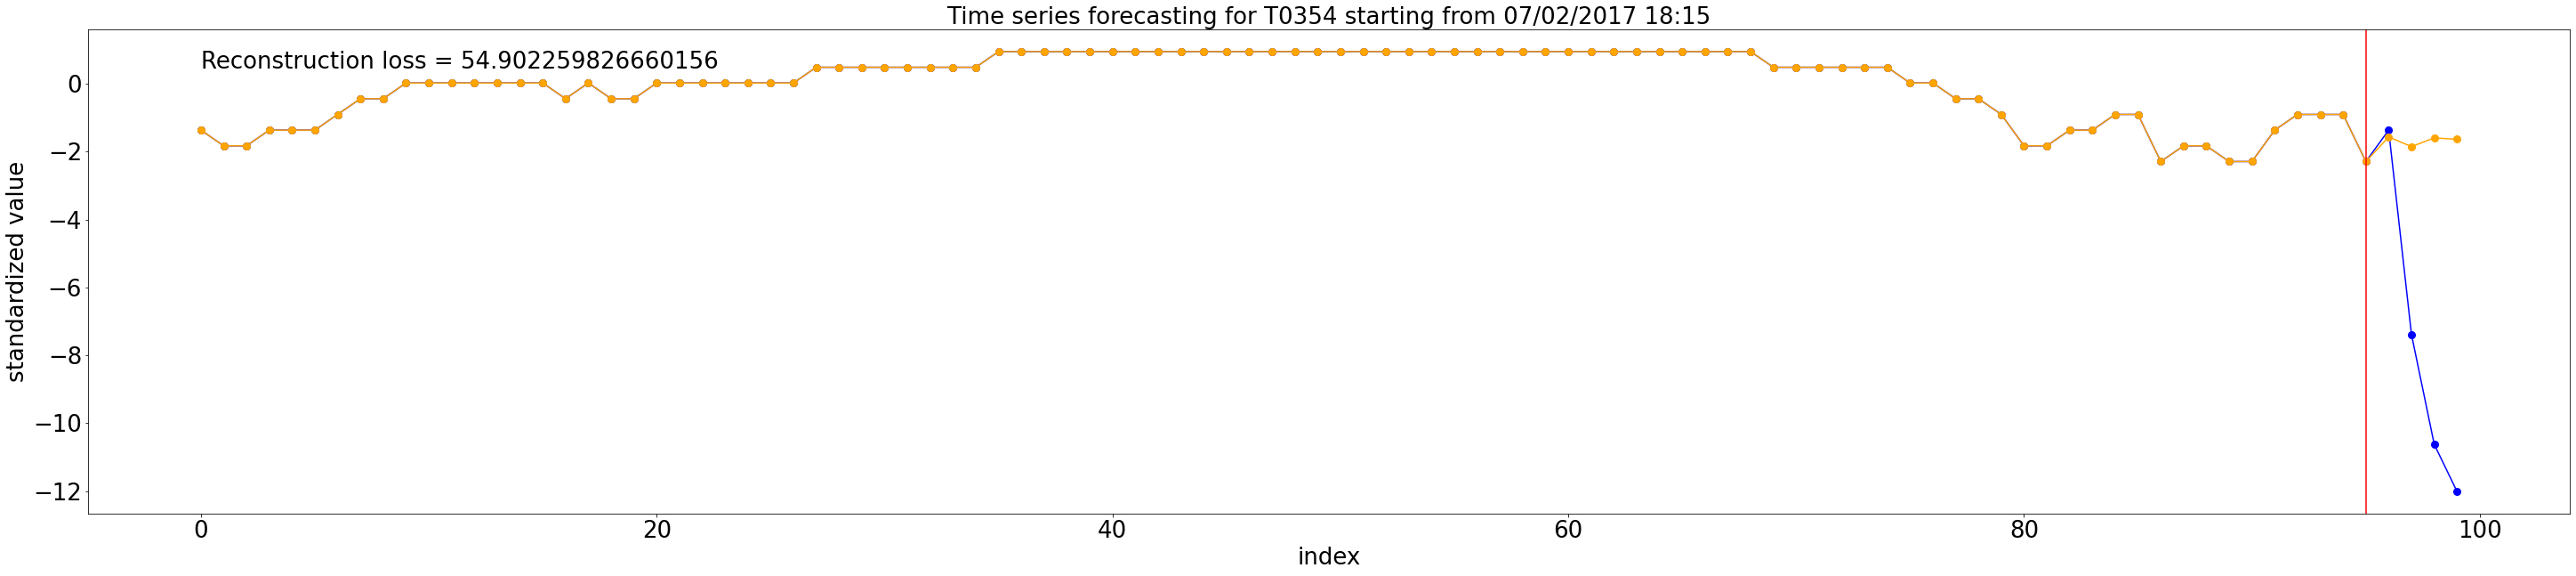

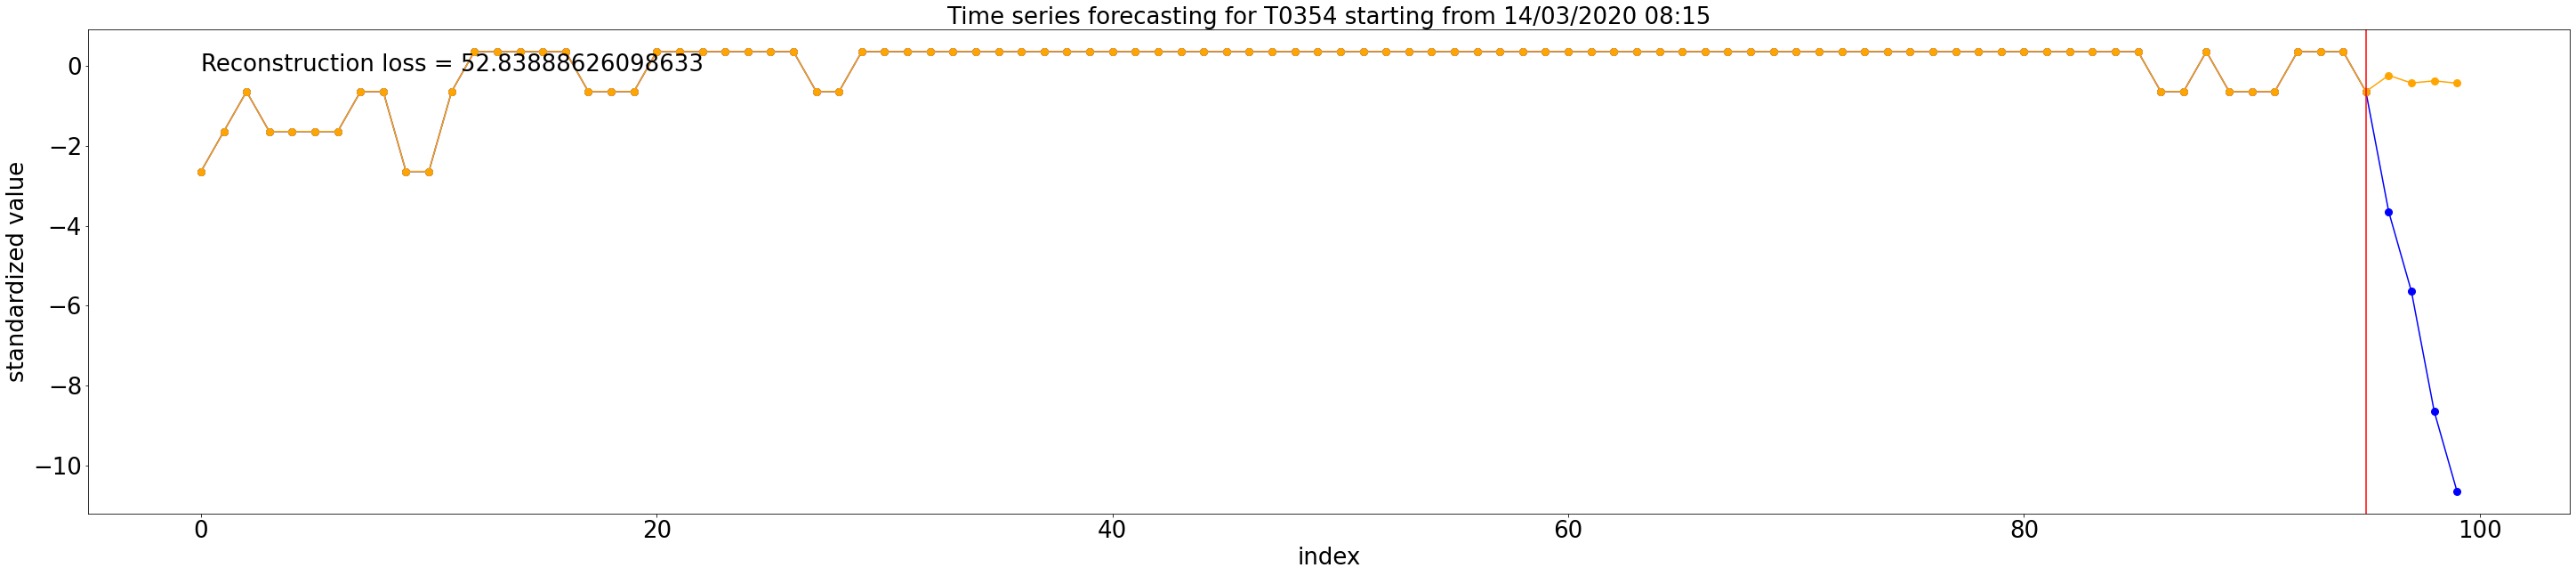

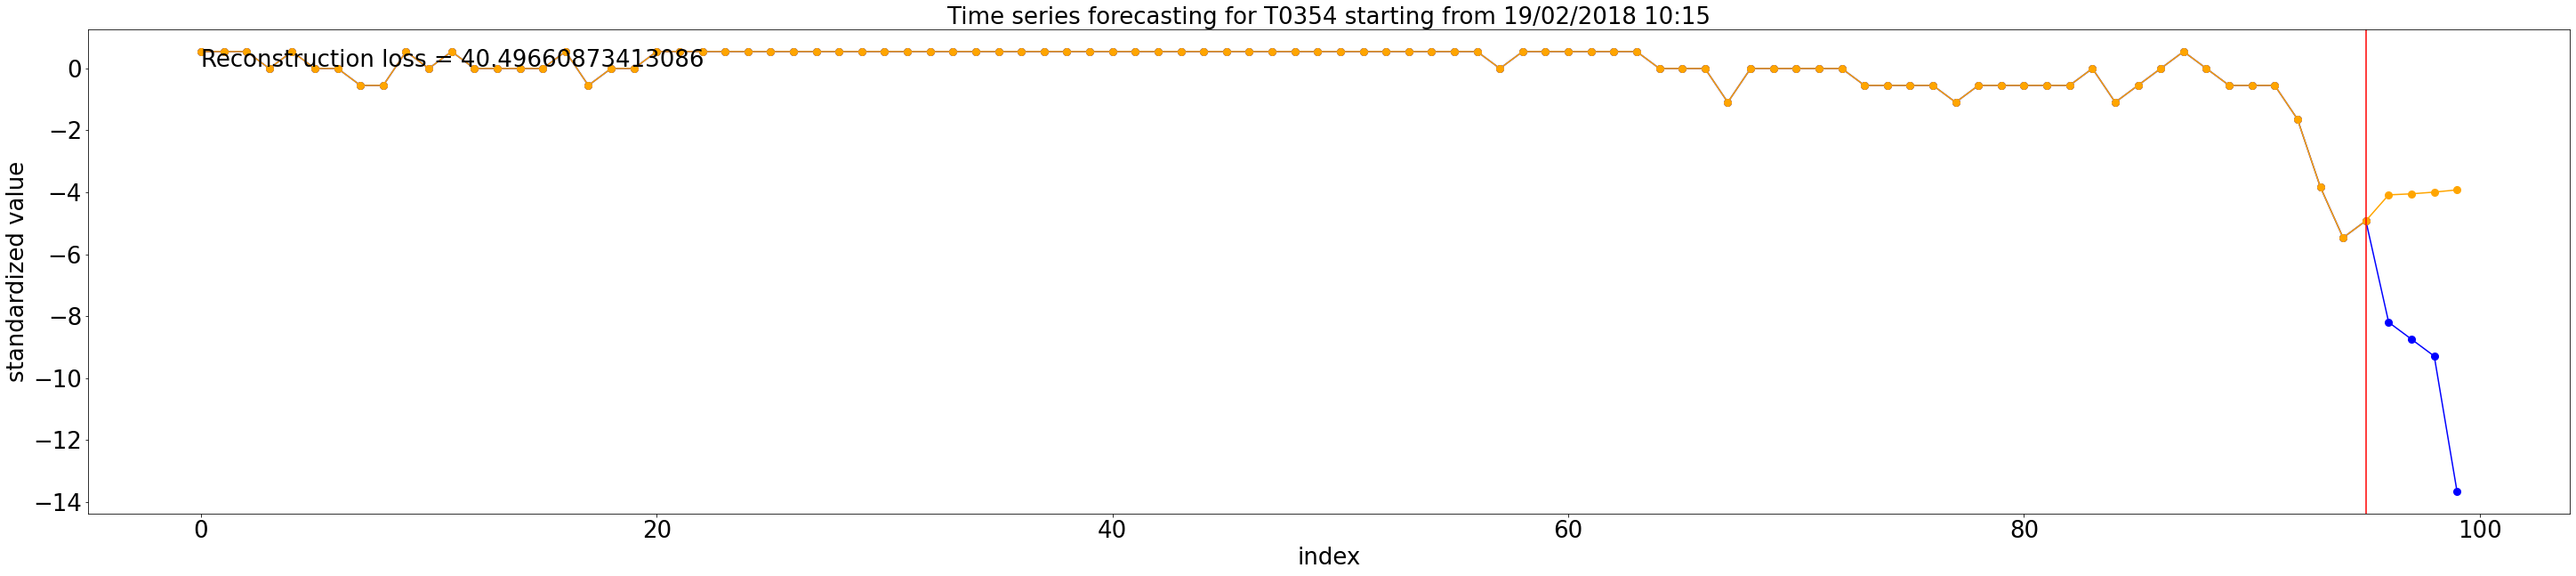

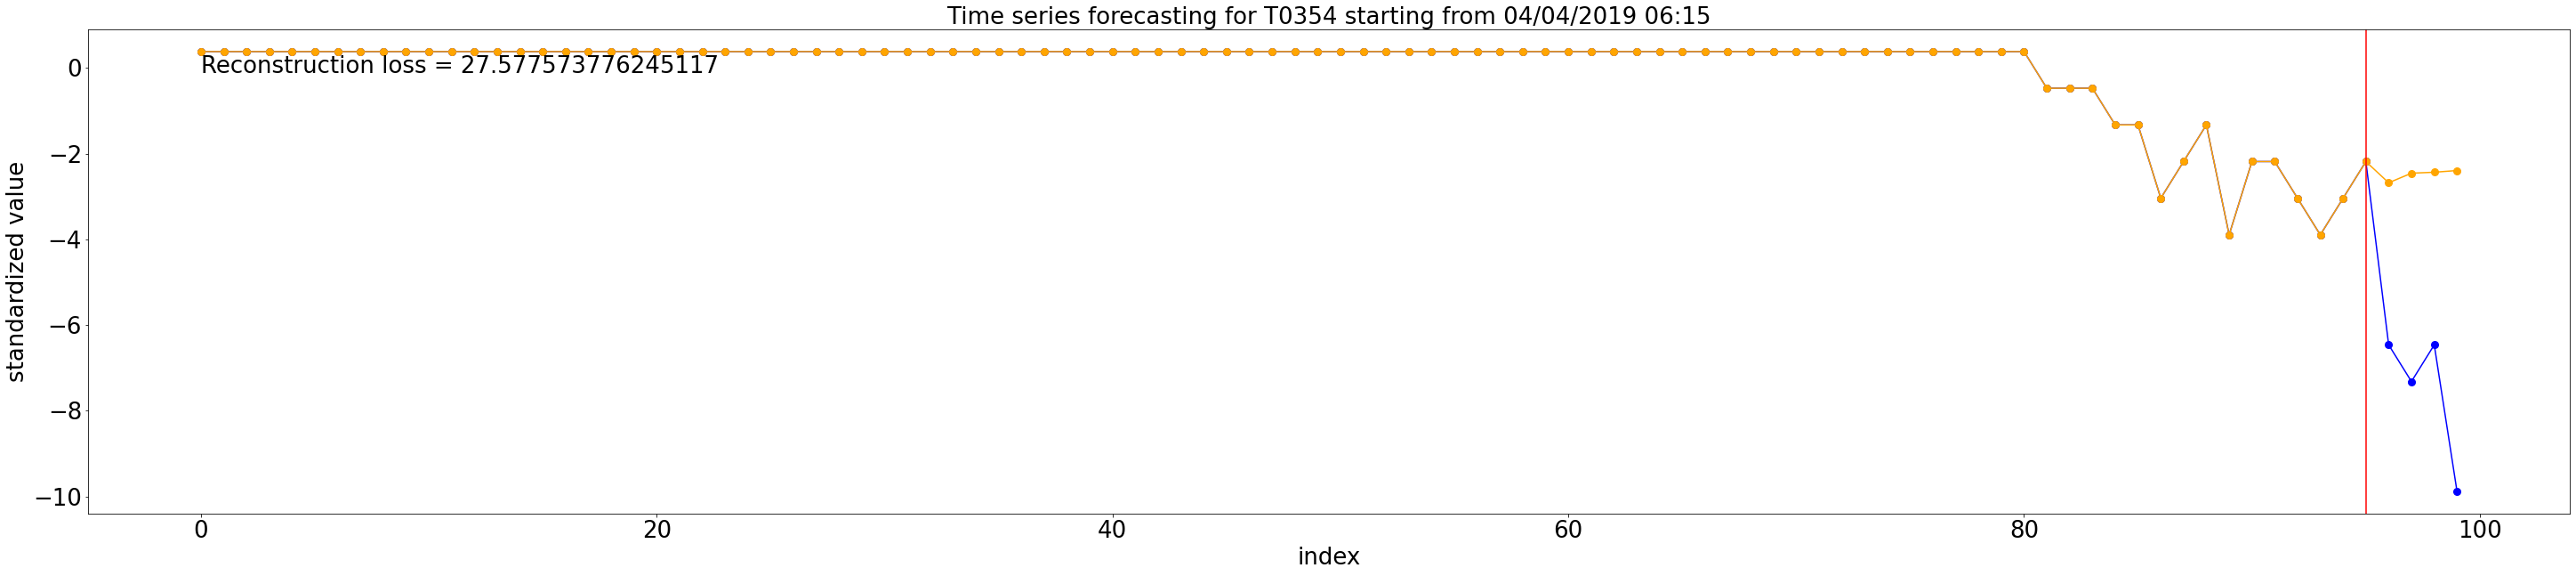

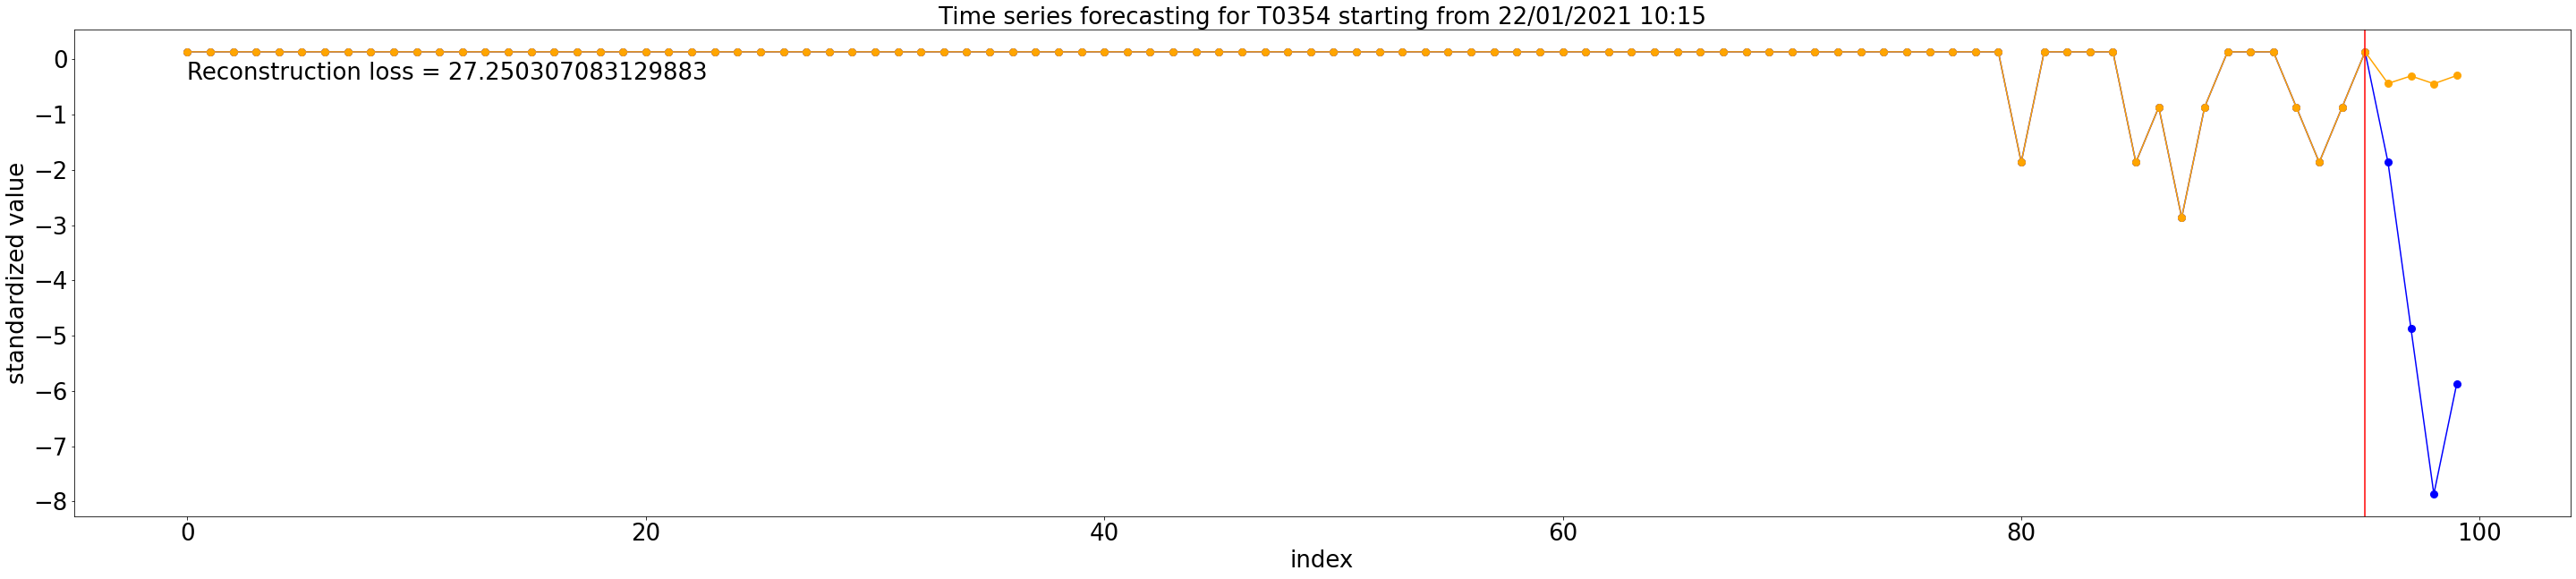

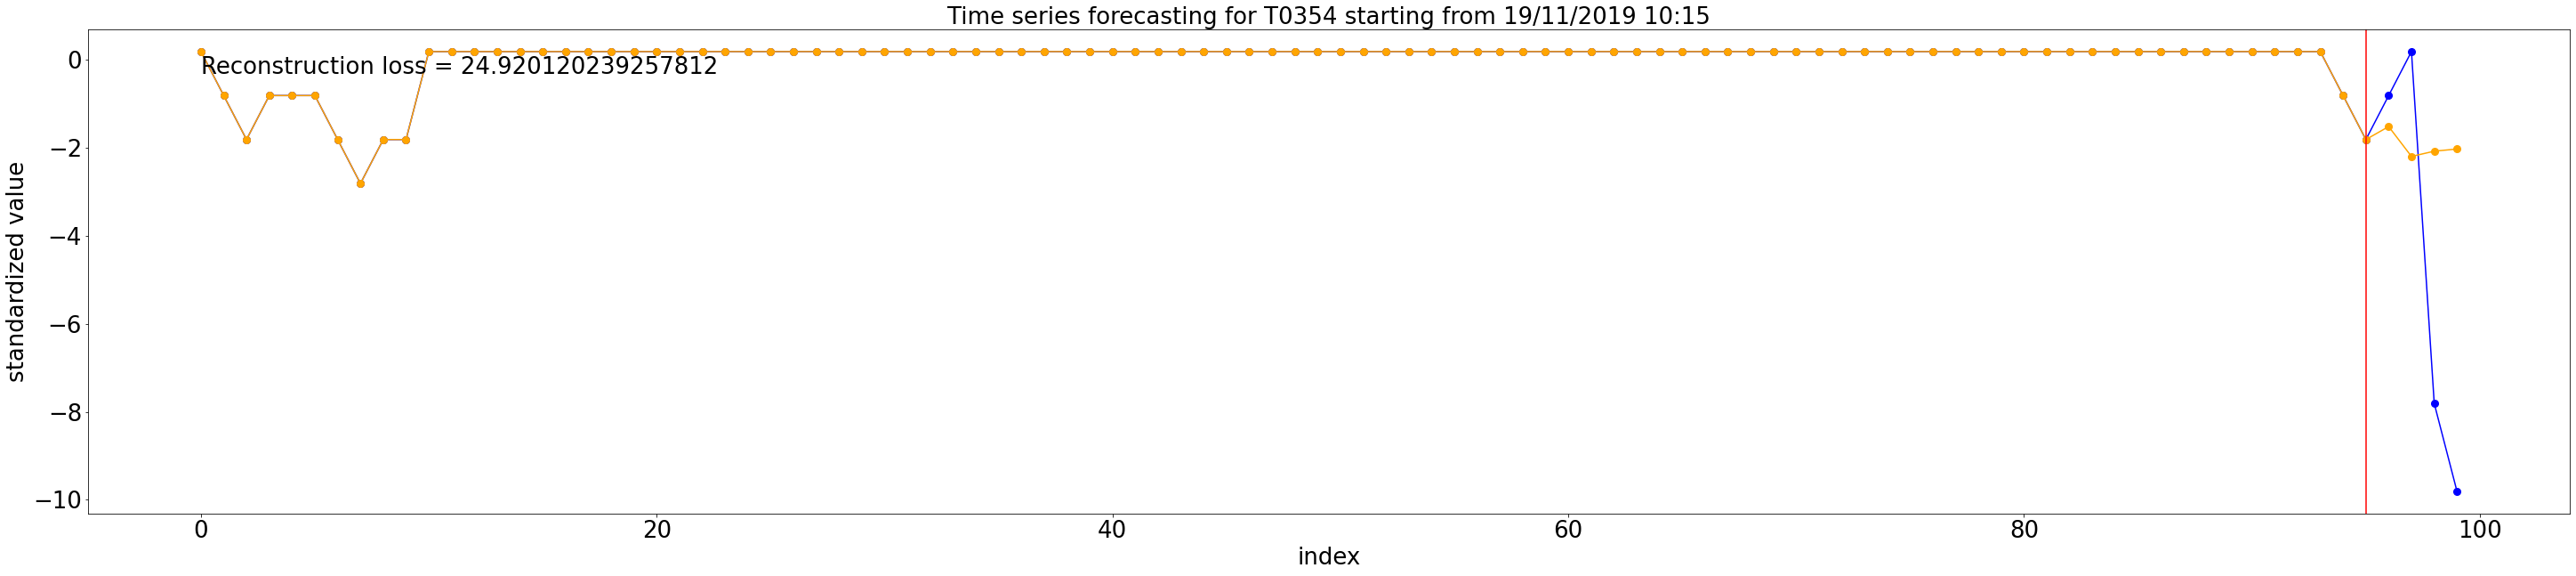

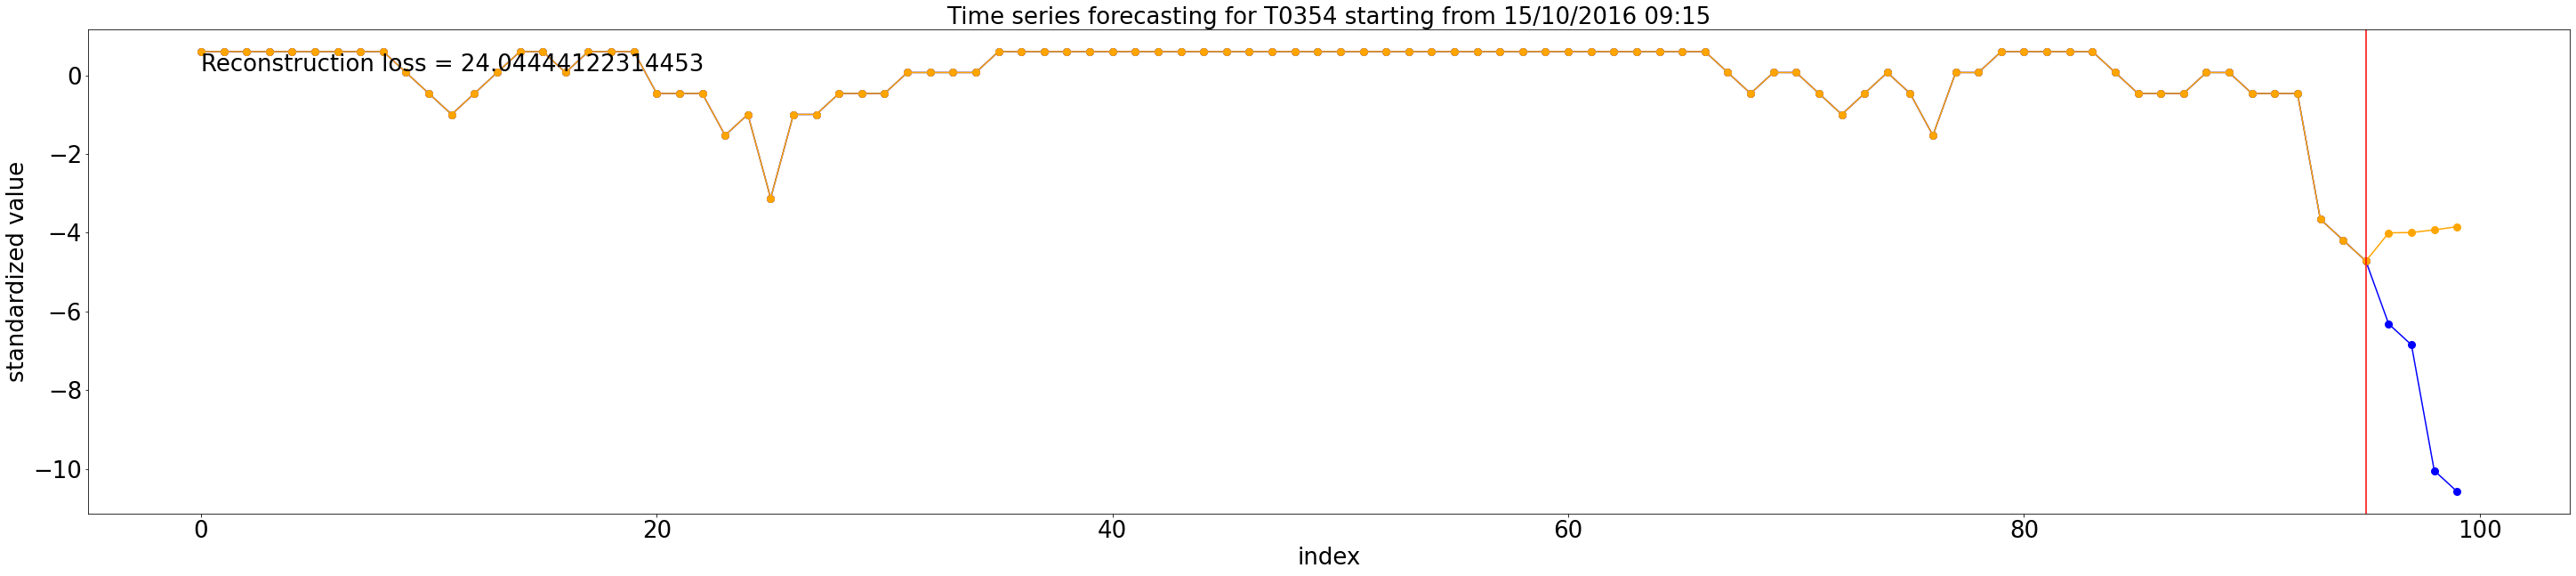

In [101]:
top_loss_indexes_list = list(top_loss_indexes.cpu().numpy())
# append validated anomalies (to be cleaned)
validated_anomalies = list(np.unique((sample_tensor_validation != 1).nonzero(as_tuple=True)[0].numpy()))
top_loss_indexes_list.extend(validated_anomalies)
for i in top_loss_indexes_list:
  f = plt.figure()
  f.set_figwidth(50)
  f.set_figheight(10)
  # single_date = str(date[i])
  plt.title(f'Time series forecasting for {sensor_code} starting from {date[i]}' ,fontsize = 26)
  plt.ylabel('standardized value',fontsize=26)
  plt.xlabel('index',fontsize=26)
  plt.xticks(fontsize=26)
  plt.yticks(fontsize=26)
  
  # find the outliers according to the validation
  y_outliers = np.where(sample_tensor_validation[i].to("cpu") == 1, np.NaN, sample_tensor_target[i].to("cpu"))
  # plt.xlim(96,102)
  original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[i]
  plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
  plt.text(0,max(original_signal)-0.5,f'Reconstruction loss = {loss[i]}',fontsize=26)
  plt.plot(reconstructed[i].to("cpu"),"o-",ms=8,color="orange")
  plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
  # plt.fill_between(line_deviation.index,under_line,over_line, color='b', alpha=.1)
  plt.axvline(x=95, color='red')
  # plt.savefig('T0010_temperature_anomaly.pdf')